In [2]:
import sys, os
print("Kernel:", sys.executable)
print("CWD:", os.getcwd())

import numpy as np, pandas as pd, astropy, matplotlib
import lightkurve as lk
import astroquery, astrocut
import transitleastsquares as tls
print("OK: imports worked")


Kernel: /Users/kobi.weitzman/miniforge3/envs/tess-ephem/bin/python
CWD: /Users/kobi.weitzman/Documents/tess-ephem
OK: imports worked


In [3]:
import lightkurve as lk
sr = lk.search_lightcurve("TIC 307210830", mission="TESS")
sr[:5]


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,SPOC,120,307210830,0.0
1,TESS Sector 02,2018,SPOC,120,307210830,0.0
2,TESS Sector 08,2019,SPOC,120,307210830,0.0
3,TESS Sector 12,2019,SPOC,120,307210830,0.0
4,TESS Sector 09,2019,SPOC,120,307210830,0.0


In [4]:
import lightkurve as lk

# Search all TESS SPOC light curves for the star "TOI 700"
sr = lk.search_lightcurve("TOI 700", mission="TESS", author="SPOC")
print(f"Found {len(sr)} light-curve files")
sr[:5]  # show a few rows


Found 57 light-curve files


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,150428135,0.0
1,TESS Sector 03,2018,SPOC,120,150428135,0.0
2,TESS Sector 04,2018,SPOC,120,150428135,0.0
3,TESS Sector 05,2018,SPOC,120,150428135,0.0
4,TESS Sector 06,2018,SPOC,120,150428135,0.0


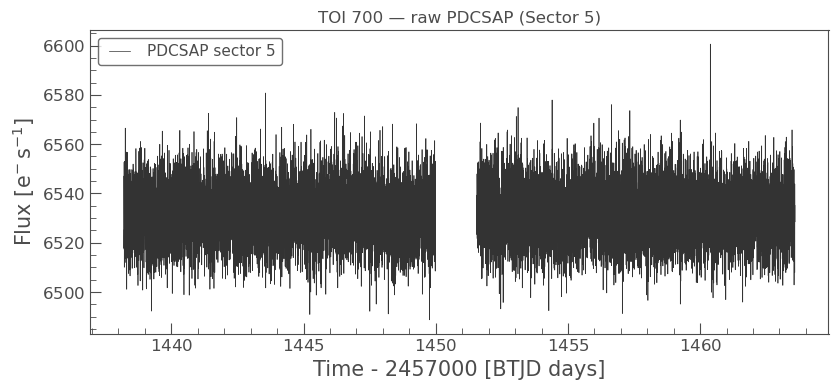

In [6]:
# Single-sector download (fast). Change sector number if you like.
import lightkurve as lk  # harmless to repeat; OK if already imported

sector = 5
lc = lk.search_lightcurve("TOI 700", mission="TESS", author="SPOC", sector=sector) \
        .download(quality_bitmask="default", download_dir="data_raw")

ax = lc.plot(label=f"PDCSAP sector {sector}")
ax.set_title(f"TOI 700 — raw PDCSAP (Sector {sector})"); ax.figure.tight_layout()


In [7]:
clean = lc.remove_nans().remove_outliers(sigma=5)
flat  = clean.flatten(window_length=201, polyorder=2)

ax = flat.plot(); ax.set_title("Flattened"); ax.figure.tight_layout()

from transitleastsquares import transitleastsquares
time = flat.time.value; flux = flat.flux.value
res = transitleastsquares(time, flux).power(period_min=0.5, period_max=30.0)
print(f"TLS best period: {res.period:.6f} d (SDE={res.SDE:.2f})")

ax = flat.fold(period=res.period, t0=res.T0).plot()
ax.set_title(f"TLS fold: P={res.period:.4f} d"); ax.figure.tight_layout()


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 37 durations
Searching 16983 data points, 2285 periods from 0.601 to 12.69 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████| 2285/2285 periods | 00:17<00:00


Searching for best T0 for period 3.98655 days


100%|█████████████████████████████████████████████████████████| 16983/16983 [00:03<00:00, 4913.11it/s]
/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/astropy/utils/decorators.py:603: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


TLS best period: 3.986554 d (SDE=5.57)


In [8]:
sectors = [5, 6]  # change these if you want
lcs = [lk.search_lightcurve("TOI 700", mission="TESS", author="SPOC", sector=s)
          .download(quality_bitmask="default", download_dir="data_raw")
       for s in sectors]
from lightkurve import LightCurveCollection
lc2 = LightCurveCollection(lcs).stitch()

flat2 = lc2.remove_nans().remove_outliers().flatten(window_length=201, polyorder=2)
from transitleastsquares import transitleastsquares
res2 = transitleastsquares(flat2.time.value, flat2.flux.value).power(period_min=0.5, period_max=30.0)
print(f"Two-sector TLS: {res2.period:.6f} d (SDE={res2.SDE:.2f})")
flat2.fold(period=res2.period, t0=res2.T0).plot();


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 42 durations
Searching 31465 data points, 5225 periods from 0.602 to 25.92 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████| 5225/5225 periods | 00:50<00:00


Searching for best T0 for period 16.05333 days


100%|█████████████████████████████████████████████████████████| 28346/28346 [00:09<00:00, 3043.63it/s]


Two-sector TLS: 16.053327 d (SDE=22.53)


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/astropy/utils/decorators.py:603: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


In [9]:
# 1) Import timing
%time import lightkurve as lk

# 2) Single-sector quick download (cached to data_raw)
sector = 5
%time lc = lk.search_lightcurve("TOI 700", mission="TESS", author="SPOC", sector=sector)\
              .download(quality_bitmask="default", download_dir="data_raw")

# 3) Clean + flatten
%time clean = lc.remove_nans().remove_outliers(sigma=5)
%time flat  = clean.flatten(window_length=201, polyorder=2)

# 4) TLS timing (first call will be slower due to JIT compilation)
from transitleastsquares import transitleastsquares
time = flat.time.value; flux = flat.flux.value
%time res = transitleastsquares(time, flux).power(period_min=0.5, period_max=30.0)
print(res.period, res.SDE)


CPU times: user 6 μs, sys: 31 μs, total: 37 μs
Wall time: 37 μs
CPU times: user 68.3 ms, sys: 28.2 ms, total: 96.5 ms
Wall time: 136 ms
CPU times: user 26.4 ms, sys: 4.05 ms, total: 30.5 ms
Wall time: 34 ms
CPU times: user 22.8 ms, sys: 4.38 ms, total: 27.2 ms
Wall time: 34.9 ms
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 37 durations
Searching 16983 data points, 2285 periods from 0.601 to 12.69 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████| 2285/2285 periods | 00:14<00:00


Searching for best T0 for period 3.98655 days


100%|█████████████████████████████████████████████████████████| 16983/16983 [00:03<00:00, 4654.54it/s]


CPU times: user 5.17 s, sys: 739 ms, total: 5.91 s
Wall time: 18.8 s
3.986554272425962 5.57418684524922


In [12]:
import lightkurve as lk

# 1) One sector only (fast). Change the sector number if needed.
sector = 5
lc = lk.search_lightcurve("TOI 700", mission="TESS", author="SPOC", sector=sector)\
        .download(quality_bitmask="default", download_dir="data_raw")

# 2) Clean + flatten
clean = lc.remove_nans().remove_outliers(sigma=5)
flat  = clean.flatten(window_length=201, polyorder=2)
flat.plot(title="TOI 700 — flattened (ready for search)");

# 3) TLS search (find the period)
from transitleastsquares import transitleastsquares
time = flat.time.value   # BTJD (TESS time)
flux = flat.flux.value
res  = transitleastsquares(time, flux).power(period_min=0.5, period_max=30.0)
print(f"TLS best period: {res.period:.6f} d, SDE={res.SDE:.2f}")

# 4) Fold & visually confirm
folded = flat.fold(period=res.period, epoch_time=res.T0)  # ← use epoch_time
binned = folded.bin(n_bins=200)
ax = folded.scatter(marker='.', s=3, alpha=0.3, label='unbinned')
binned.plot(ax=ax, label='binned (200)')
ax.set_title(f"Folded at P={res.period:.5f} d (TLS)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.legend(); ax.figure.tight_layout()

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 37 durations
Searching 16983 data points, 2285 periods from 0.601 to 12.69 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████| 2285/2285 periods | 00:15<00:00


Searching for best T0 for period 3.98655 days


100%|█████████████████████████████████████████████████████████| 16983/16983 [00:03<00:00, 4901.36it/s]


TLS best period: 3.986554 d, SDE=5.57


In [13]:
P_days   = res.period                 # period (days) — how often the transit repeats
T0_btjd  = res.T0                     # reference mid-time in BTJD (TESS's time axis)
dur_hrs  = res.duration * 24          # transit duration (hours)
depth_ppm= res.depth * 1e6            # transit depth (ppm). sqrt(depth) ~ Rp/R*
print(f"P={P_days:.6f} d, T0(BTJD)={T0_btjd:.6f}, duration≈{dur_hrs:.2f} h, depth≈{depth_ppm:.0f} ppm")


P=3.986554 d, T0(BTJD)=1440.471587, duration≈0.40 h, depth≈999343 ppm


In [14]:
from astropy.time import Time

def btjd_to_utc_iso(btjd):
    t = Time(btjd + 2457000.0, format='jd', scale='tdb')  # TESS convention
    return t.utc.iso

for n in range(1, 4):
    when = btjd_to_utc_iso(T0_btjd + n*P_days)
    print(f"Transit {n}: {when} (UTC)")

Transit 1: 2018-11-21 22:58:34.244 (UTC)
Transit 2: 2018-11-25 22:39:12.533 (UTC)
Transit 3: 2018-11-29 22:19:50.822 (UTC)


In [15]:
from transitleastsquares import transitleastsquares
half = 0.05 * P_days
res_ref = transitleastsquares(flat.time.value, flat.flux.value).power(
    period_min=P_days - half, period_max=P_days + half
)
print(f"Refined: P={res_ref.period:.6f} d, SDE={res_ref.SDE:.2f}")


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/grid.py:149: UserWarning: period_grid defaults to R_star=1 and M_star=1 as given density yielded grid with too few values
  warnings.warn(


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 37 durations
Searching 16983 data points, 2285 periods from 0.601 to 12.69 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████| 2285/2285 periods | 00:14<00:00


Searching for best T0 for period 3.98655 days


100%|█████████████████████████████████████████████████████████| 16983/16983 [00:03<00:00, 5026.34it/s]


Refined: P=3.986554 d, SDE=5.57


In [16]:
import lightkurve as lk
sectors = [5, 6]  # pick two that exist for your star
lcs = [lk.search_lightcurve("TOI 700", mission="TESS", author="SPOC", sector=s)
         .download(quality_bitmask="default", download_dir="data_raw")
       for s in sectors]
from lightkurve import LightCurveCollection
lc2 = LightCurveCollection(lcs).stitch()
flat2 = lc2.remove_nans().remove_outliers(sigma=5).flatten(window_length=201, polyorder=2)

res2 = transitleastsquares(flat2.time.value, flat2.flux.value).power(period_min=0.5, period_max=30.0)
print(f"Two sectors: P={res2.period:.6f} d, SDE={res2.SDE:.2f}")
flat2.fold(period=res2.period, epoch_time=res2.T0).bin(n_bins=200).plot();

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 42 durations
Searching 31465 data points, 5225 periods from 0.602 to 25.92 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████| 5225/5225 periods | 00:34<00:00


Searching for best T0 for period 16.05333 days


100%|█████████████████████████████████████████████████████████| 28346/28346 [00:08<00:00, 3483.83it/s]


Two sectors: P=16.053327 d, SDE=22.53


In [17]:
P1 = 3.986554     # first run
P2 = 16.053327    # two-sector run
print("P2 / P1 ≈", P2 / P1)  # should be ~4.0


P2 / P1 ≈ 4.0268680670072445


In [18]:
P = res2.period        # ≈ 16.053327 days
T0 = res2.T0           # reference mid-time in BTJD
folded = flat2.fold(period=P, epoch_time=T0)  # use epoch_time in Lightkurve v2
binned  = folded.bin(n_bins=200)

ax = folded.scatter(marker='.', s=3, alpha=0.25, label='unbinned')
binned.plot(ax=ax, label='binned (200)')
ax.set_title(f"Folded at P={P:.6f} d (two sectors)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend(); ax.figure.tight_layout()


In [19]:
dur_hrs   = res2.duration * 24
depth_ppm = res2.depth * 1e6
print(f"P={P:.6f} d, T0(BTJD)={T0:.6f}, duration≈{dur_hrs:.2f} h, depth≈{depth_ppm:.0f} ppm")


P=16.053327 d, T0(BTJD)=1452.441755, duration≈1.24 h, depth≈998462 ppm


In [20]:
from astropy.time import Time

def btjd_to_utc(btjd):
    return Time(btjd + 2457000.0, format='jd', scale='tdb').utc.iso

for n in range(1, 4):
    print(f"Transit {n}: {btjd_to_utc(T0 + n*P)} (UTC)")


Transit 1: 2018-12-15 23:51:45.924 (UTC)
Transit 2: 2019-01-01 01:08:33.407 (UTC)
Transit 3: 2019-01-17 02:25:20.890 (UTC)


In [21]:
# Refine ±3% around the peak
from transitleastsquares import transitleastsquares
half = 0.03 * P
ref   = transitleastsquares(flat2.time.value, flat2.flux.value).power(
          period_min=P-half, period_max=P+half)
P, T0 = ref.period, ref.T0
print(f"Refined: P={P:.6f} d, SDE={ref.SDE:.2f}")

# Save the folded figure
import pathlib
pathlib.Path("figures").mkdir(exist_ok=True)
folded = flat2.fold(period=P, epoch_time=T0).bin(n_bins=200).plot()
folded.figure.savefig("figures/target_folded_two_sectors.png", dpi=150)


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/grid.py:149: UserWarning: period_grid defaults to R_star=1 and M_star=1 as given density yielded grid with too few values
  warnings.warn(


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 42 durations
Searching 31465 data points, 5225 periods from 0.602 to 25.92 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████| 5225/5225 periods | 00:46<00:00


Searching for best T0 for period 16.05333 days


100%|█████████████████████████████████████████████████████████| 28346/28346 [00:09<00:00, 3099.61it/s]


Refined: P=16.053327 d, SDE=22.53
